In [1]:
from math import pi
import numpy as np
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import cv2
from matplotlib import pyplot as plt
from qiskit.circuit.library import *
c4xgate = C4XGate()
c3xgate = C3XGate()
ccxgate = CCXGate()

In [2]:
#本实验为Lena的QRMW彩色图像制备
#复线QRMW论文中关于彩色图像的实现验证

In [3]:
picture_path = 'lenna.jpeg'

img = cv2.imread(picture_path, 1)

In [4]:
#由于计算内存有限，因此将图片缩放为32*32，这样描述一张Lena的RGB彩色图像需要24个量子比特（算上中间的辅助位）
#一共是2+10+4+8，其中2是颜色通道索引，10位xy位置信息，4位是将10cnot门，分解为多组4cnot门组合的辅助位，8位存储颜色信息
channel_B = cv2.resize(img[:, :, 0], (32,32))
channel_G = cv2.resize(img[:, :, 1], (32,32))
channel_R = cv2.resize(img[:, :, 2], (32,32))

In [5]:
channel_R.shape

(32, 32)

In [6]:
channel_R

array([[226, 223, 231, ..., 195, 198, 175],
       [229, 223, 228, ..., 198, 156,  92],
       [225, 231, 228, ..., 159,  97,  99],
       ...,
       [ 96, 185, 232, ..., 156, 146, 117],
       [159, 195, 229, ..., 126, 161, 114],
       [ 99, 224, 230, ..., 153, 135, 106]], dtype=uint8)

In [7]:
#将实际的位置信息和颜色信息转位2进制数据串，用于建立实际的量子电路
x = 32 
y = 32
index = x*y

channel_R_color_list = []
channel_R_index_list = []
channel_G_color_list = []
channel_G_index_list = []
channel_B_color_list = []
channel_B_index_list = []

#在位置信息前加上对应的颜色通道索引信息
for j in range(index):
    channel_R_index_list.append('00' + bin(j).replace('0b','').zfill(10))
    channel_G_index_list.append('01' + bin(j).replace('0b','').zfill(10))
    channel_B_index_list.append('10' + bin(j).replace('0b','').zfill(10))


for j in range(x):
    for k in range(y):
        channel_R_color_list.append(bin(channel_R[j][k]).replace('0b','').zfill(8))
        channel_G_color_list.append(bin(channel_G[j][k]).replace('0b','').zfill(8))
        channel_B_color_list.append(bin(channel_B[j][k]).replace('0b','').zfill(8))

In [7]:
#若颜色信息对应的比特为0，则不做任何操作，故可将这些省去，只统计为1的部分以及每个1所在的位置
#即00为索引通道信息 1110011100为位置信息 6表示的8位颜色比特中第7位为1
#gateValueMap中所含的数据为0011100111006这样的形式
gateValueMap_R = {}
gateValueMap_G = {}
gateValueMap_B = {}
for pos in range(index):
    for cindex in range(8):
        if channel_R_color_list[pos][cindex] == '1':
            key = channel_R_index_list[pos] + str(cindex)
            gateValueMap_R[key] = 1
        if channel_G_color_list[pos][cindex] == '1':
            key = channel_G_index_list[pos] + str(cindex)
            gateValueMap_G[key] = 1
        if channel_B_color_list[pos][cindex] == '1':
            key = channel_B_index_list[pos] + str(cindex)
            gateValueMap_B[key] = 1

In [8]:
#获取当前图像中所有需要操作的2进制信息串
keySet_R = gateValueMap_R.keys()
keySet_G = gateValueMap_G.keys()
keySet_B = gateValueMap_B.keys()

In [9]:
keySetList_R = []
keySetList_G = []
keySetList_B = []
#将数据转化为list更容易操作
for i in keySet_R:
    keySetList_R.append(i)
    
for i in keySet_G:
    keySetList_G.append(i)

for i in keySet_B:
    keySetList_B.append(i)    

In [10]:
#此处开始压缩，当二进制信息串中，控制位也就是最后一个数字位相同的情况下，之前的信息中只有一位不同，则那一位可以作为*
#意为此处，为1或者为0考姜楠了老师的论文A novel quantum image compression method based on JPEG和张毅老师的NEQR都可以，即无需控制
#详见于考姜楠了老师的论文A novel quantum image compression method based on JPEG和张毅老师的NEQR
lenKeySetList_R = len(keySetList_R)
pre_R = lenKeySetList_R

while(1):
    deletePos = []
    deleteNode = []
    for i in range(lenKeySetList_R):
        if i in deletePos:
            continue
        for j in range(i+1, lenKeySetList_R):
            flag = 0
            pos = 0
            if keySetList_R[i][12] == keySetList_R[j][12]:
                for k in range(12):
                    if keySetList_R[i][k] != keySetList_R[j][k]:
                        flag += 1
                        pos = k
                if flag == 1:
                    strList = list(keySetList_R[i])
                    strList[pos] = '*'
                    keySetList_R[i] = "".join(strList)
                    deletePos.append(j)
                    deleteNode.append(keySetList_R[j])
                break
                
    print(len(deletePos))
    for l in deleteNode:
        keySetList_R.remove(l)
    lenKeySetList_R = len(keySetList_R)
    if pre_R == lenKeySetList_R:
        break
    pre_R = lenKeySetList_R

1696
384
82
17
1
0


In [11]:
#同上
lenKeySetList_G = len(keySetList_G)
pre_G = lenKeySetList_G

while(1):
    deletePos = []
    deleteNode = []
    for i in range(lenKeySetList_G):
        if i in deletePos:
            continue
        for j in range(i+1, lenKeySetList_G):
            flag = 0
            pos = 0
            if keySetList_G[i][12] == keySetList_G[j][12]:
                for k in range(12):
                    if keySetList_G[i][k] != keySetList_G[j][k]:
                        flag += 1
                        pos = k
                if flag == 1:
                    strList = list(keySetList_G[i])
                    strList[pos] = '*'
                    keySetList_G[i] = "".join(strList)
                    deletePos.append(j)
                    deleteNode.append(keySetList_G[j])
                break
                
    print(len(deletePos))
    for l in deleteNode:
        keySetList_G.remove(l)
    lenKeySetList_G = len(keySetList_G)
    if pre_G == lenKeySetList_G:
        break
    pre_G = lenKeySetList_G

1290
185
11
0


In [12]:
#同上
lenKeySetList_B = len(keySetList_B)
pre_B = lenKeySetList_B

while(1):
    deletePos = []
    deleteNode = []
    for i in range(lenKeySetList_B):
        if i in deletePos:
            continue
        for j in range(i+1, lenKeySetList_B):
            flag = 0
            pos = 0
            if keySetList_B[i][12] == keySetList_B[j][12]:
                for k in range(12):
                    if keySetList_B[i][k] != keySetList_B[j][k]:
                        flag += 1
                        pos = k
                if flag == 1:
                    strList = list(keySetList_B[i])
                    strList[pos] = '*'
                    keySetList_B[i] = "".join(strList)
                    deletePos.append(j)
                    deleteNode.append(keySetList_B[j])
                break
                
    print(len(deletePos))
    for l in deleteNode:
        keySetList_B.remove(l)
    lenKeySetList_B = len(keySetList_B)
    if pre_B == lenKeySetList_B:
        break
    pre_B = lenKeySetList_B

1416
262
36
5
0


In [13]:
#实际的数据串形式
#最后压缩后，所需门的数量只有原来的1/4到1/3
keySetList = keySetList_R + keySetList_G + keySetList_B
for line in keySetList:
    if line[0:2] == '01':
        print(line)

01000000000*0
010000000**05
0100000000*07
0100000000100
01000000001*4
01000000001*6
0100000000111
0100000000112
0100000000113
0100000000117
0100000001002
0100000001003
0100000001**4
0100000001006
0100000001011
01000000011*1
0100000001107
0100000001113
0100000001115
0100000001116
010000001***1
010000001***2
0100000010*05
0100000010*16
01000000101*7
01000000110*5
0100000011**7
01000000111*6
0100000100**1
01000001000*2
0100000100102
0100000100113
0100000100115
0100000100117
0100000101001
0100000101002
0100000101004
0100000101010
0100000101016
0100000101017
01000001011*0
01000001011*7
01000001100*0
0100000110006
0100000110012
0100000110013
0100000110*14
010000011*015
0100000110*17
0100000110100
01000001101*3
0100000110111
0100000110116
0100000111**1
01000001110*3
01000001110*4
0100000111006
0100000111102
0100000111114
0100000111115
0100000111116
01000010000*0
0100001000*05
01000010000*7
0100001000016
0100001000100
010000100*1*4
0100001000111
0100001000112
010000100*113
0100001000117
010000

0101011110111
0101011110112
0101011110115
0101011110117
01010111110*4
0101011111*05
0101011111*07
0101011111010
01010111111*0
0101011111115
01011000000*1
0101100000004
0101100000015
01011000001*0
0101100000103
0101100000105
0101100000114
0101100001**2
0101100001**3
0101100001**6
0101100001**7
0101100001014
0101100001015
0101100001104
01011000011*5
0101100010000
01011000100*3
01011000100*4
0101100010011
0101100010015
0101100010016
0101100010*17
01011000101*1
0101100010103
0101100010104
0101100010105
01011000101*6
0101100010112
01011000110*2
0101100011*03
0101100011*04
0101100011015
0101100011017
01011000111*5
0101100011107
0101100011111
0101100011114
0101100100*04
01011001000*5
0101100100*07
0101100100010
0101100100012
0101100100013
0101100100*16
01011001001*0
01011001001*2
0101100100117
0101100101000
0101100101*02
01011001010*3
0101100101005
0101100101**7
0101100101011
0101100101016
0101100101101
0101100101103
0101100101104
01011001011*6
0101100101110
0101100101112
0101100101115
010110

0111001100007
0111001100014
01110011001*0
01110011001*4
01110011001*6
0111001100112
0111001100115
0111001100117
01110011010*0
01110011010*2
0111001101003
0111001101004
01110011010*5
0111001101**6
01110011010*7
0111001101102
0111001101107
0111001101110
0111001101114
01110011100*2
01110011100*3
011100111**04
01110011100*5
0111001110*06
011100111***7
01110011101*1
011100111*103
0111001110105
0111001110112
01110011110*0
0111001111001
01110011110*5
01110011110*6
0111001111012
0111001111102
0111001111105
0111001111111
0111001111116
01110100000*1
0111010000**3
0111010000*05
0111010000014
0111010000*17
0111010*001*0
01110100001*6
0111010000115
01110100010*3
0111010001**6
0111010001015
0111010001017
0111010001101
0111010001104
0111010001113
01110100100*1
0111010010*06
0111010010*07
0111010010014
0111010010102
01110100101*3
0111010010105
0111010010116
0111010010117
0111010011**3
01110100110*4
0111010011006
0111010011017
01110100111*1
0111010011114
0111010011115
01110101000*1
01110101000*2
011101

In [14]:
import queue

In [15]:
#此处是为了计算n-cnot门的分解形式
#即颜色通道数为2，位置信息数为10，则可认为在实际制备量子图像是通过12-cnot进行操作的
#因此需要将12-cnot门分解为4cnot，3cnot，2cnot和单量子门的组合
QuantumGateDecList = []
#第12，13，14，15位量子比特为辅助位
auxiliaryQubits = 12
#16-23为颜色位
colorStartQubit = 16
#从2进制数据串中读取数据
for element in keySetList:
    QuantumGateDecQue = queue.Queue()
    #将妹一条2进制串的数据入队
    for ele in range(len(element) - 1):
        #遇到*直接跳过
        if element[ele] == '*':
            continue
        #将该条2进制串的实际数据入队
        QuantumGateDecQue.put({ele : element[ele]})
    QuantumGateDecLevelList = []
    count = 0;
    tempRecoverGate = []
    #当队中数据大于4时，则表示可以分解为4cnot门
    while QuantumGateDecQue.qsize() > 4 :
        childGateList = []
        for num in range(4):
            #将4cnot门的控制信息存入
            childGateList.append(QuantumGateDecQue.get())
        #将受控信息存入
        childGateList.append(auxiliaryQubits + count)
        #将完整的4cnot数据存储
        QuantumGateDecLevelList.append(childGateList)
        tempRecoverGate.append(childGateList)
        QuantumGateDecQue.put({auxiliaryQubits + count: -1})
#         print(QuantumGateDecLevelList)
#         break
        count += 1
    test = []
    #将剩余无法构成4cnot的门数据转为3cnot或者2cnot存入
    while QuantumGateDecQue.qsize() > 0:
#         childGateList.append(QuantumGateDecQue.get())
        test.append(QuantumGateDecQue.get())
#     childGateList.append(colorStartQubit + int(element[12]))
    test.append(colorStartQubit + int(element[12]))
#     QuantumGateDecLevelList.append(childGateList)
    QuantumGateDecLevelList.append(test)
    #重复量子电路，用于数据复位
    for i in range(len(tempRecoverGate)):
        QuantumGateDecLevelList.append(tempRecoverGate[len(tempRecoverGate) - 1 - i])
    QuantumGateDecList.append(QuantumGateDecLevelList)
    

In [16]:
QuantumGateDecList

[[[{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12],
  [{4: '0'}, {5: '0'}, {6: '0'}, {12: -1}, 16],
  [{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12]],
 [[{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12],
  [{4: '0'}, {5: '0'}, {6: '0'}, {7: '0'}, 13],
  [{8: '0'}, {9: '0'}, {12: -1}, {13: -1}, 17],
  [{4: '0'}, {5: '0'}, {6: '0'}, {7: '0'}, 13],
  [{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12]],
 [[{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12],
  [{4: '0'}, {5: '0'}, {6: '0'}, {7: '0'}, 13],
  [{8: '0'}, {9: '0'}, {11: '0'}, {12: -1}, 14],
  [{13: -1}, {14: -1}, 18],
  [{8: '0'}, {9: '0'}, {11: '0'}, {12: -1}, 14],
  [{4: '0'}, {5: '0'}, {6: '0'}, {7: '0'}, 13],
  [{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12]],
 [[{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12],
  [{4: '0'}, {5: '0'}, {6: '0'}, {7: '0'}, 13],
  [{8: '0'}, {9: '0'}, {12: -1}, {13: -1}, 22],
  [{4: '0'}, {5: '0'}, {6: '0'}, {7: '0'}, 13],
  [{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12]],
 [[{0: '0'}, {1: '0'}, {2: '0'}, {3: '0'}, 12],
  [{4:

In [17]:
from qiskit import *
qc = QuantumCircuit(24, 20)
for i in range(12):
    qc.h(i)

In [18]:
def applyGate(qc, decomPose, controlList):
    if len(decomPose) == 5:
            qc.append(c4xgate, controlList)
    elif len(decomPose) == 4:
        qc.append(c3xgate, controlList)
    elif len(decomPose) == 3:
        qc.append(ccxgate, controlList)

In [19]:
#建立实际线路表
for gate in QuantumGateDecList:
    gateLen = len(gate)
    for decomPose in gate:
        controlList = []
        for index in range(len(decomPose)-1):
            for key in decomPose[index].keys():
                if decomPose[index][key] == '0':
                    qc.x(int(key))
                controlList.append(int(key))
        controlList.append(decomPose[len(decomPose)-1])
        applyGate(qc, decomPose, controlList)
        for index in range(len(decomPose)-1):
            for key in decomPose[index].keys():
                if decomPose[index][key] == '0':
                    qc.x(int(key))
        qc.barrier()

In [ ]:
#可以将整个线路打印看看，非常的大
qc.draw()

In [20]:
for i in range(12):
    qc.measure(i, 19 - i)

for j in range(8):
    qc.measure(16 + j, 7 - j)

In [21]:
#同前
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc, shots=40000)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)

{'00101011100111001000': 7, '10001011010101101111': 7, '01001110111110101100': 12, '00011110000110100100': 6, '10100100101101000011': 8, '11010000001000000000': 9, '10001001110000111010': 10, '10100101010001111110': 15, '01100011000001011000': 14, '01111110000111000111': 10, '00000000110011001111': 13, '11100010011000000000': 5, '11101100000000000000': 10, '10001111101101000100': 6, '00111101100010100000': 6, '11010001100000000000': 12, '10101000100100111101': 6, '11100100111100000000': 9, '00011000110101101001': 11, '10100000001101101110': 7, '11100000111000000000': 12, '10010010001101100101': 7, '11101101000000000000': 9, '10110010100110101101': 13, '00000010110111010000': 12, '01010111110010001101': 6, '00000000111011001101': 10, '01101100110000010110': 16, '01011010101100111100': 9, '00100111011111001011': 13, '11000000110000000000': 15, '01110001101101101101': 12, '00011111010110110110': 10, '11001111110000000000': 17, '10110110011010000011': 14, '00101011001011101000': 10, '00010

/Users/zsc/opt/anaconda3/envs/qiskit/lib/python3.6/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


In [22]:
bitPlane = []
for i in counts:
    bitPlane.append(i)

In [29]:
channel0_0 = {}
channel0_1 = {}
channel1_0 = {}
for element in bitPlane:
    if element[0:2] == '00':
        key = int(element[2:12], 2)
        val = int(element[12:20], 2)
        channel0_0[key] = val
    elif element[0:2] == '01':
        key = int(element[2:12], 2)
        val = int(element[12:20], 2)
        channel0_1[key] = val
    elif element[0:2] == '10':
        key = int(element[2:12], 2)
        val = int(element[12:20], 2)
        channel1_0[key] = val

In [30]:
channel0_0

{697: 200,
 481: 164,
 12: 207,
 984: 160,
 397: 105,
 45: 208,
 14: 205,
 631: 203,
 501: 182,
 690: 232,
 353: 198,
 550: 189,
 831: 159,
 615: 104,
 3: 227,
 251: 102,
 964: 79,
 443: 213,
 841: 126,
 26: 213,
 281: 236,
 551: 85,
 974: 214,
 836: 78,
 302: 226,
 180: 162,
 129: 166,
 1020: 134,
 372: 219,
 70: 179,
 289: 179,
 493: 77,
 628: 223,
 540: 206,
 78: 202,
 161: 171,
 247: 82,
 560: 204,
 659: 216,
 890: 176,
 877: 123,
 577: 119,
 359: 216,
 879: 216,
 523: 148,
 53: 225,
 805: 78,
 323: 234,
 305: 219,
 250: 84,
 562: 213,
 46: 205,
 858: 173,
 300: 214,
 797: 242,
 590: 211,
 113: 204,
 438: 174,
 713: 217,
 972: 143,
 21: 222,
 653: 156,
 866: 237,
 122: 217,
 985: 138,
 954: 231,
 43: 210,
 787: 231,
 971: 86,
 843: 79,
 780: 95,
 187: 79,
 38: 181,
 245: 224,
 51: 195,
 616: 81,
 276: 218,
 769: 140,
 920: 192,
 385: 188,
 36: 170,
 195: 225,
 4: 165,
 29: 195,
 444: 212,
 416: 177,
 182: 221,
 680: 149,
 478: 205,
 580: 161,
 888: 192,
 511: 189,
 903: 86,
 535: 1

In [31]:
channel_R = []
channel_G = []
channel_B = []
for i in range(1024):
    channel_R.append(channel0_0[i])
    channel_G.append(channel0_1[i])
    channel_B.append(channel1_0[i])    

In [34]:
channel_R = np.array(channel_R).reshape(32, 32, 1)
channel_G = np.array(channel_G).reshape(32, 32, 1)
channel_B = np.array(channel_B).reshape(32, 32, 1)

In [35]:
Image = np.dstack((channel_R, channel_G))
Image = np.dstack((Image, channel_B))

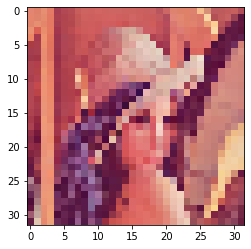

In [36]:
plt.imshow(Image)